In [3]:
import torch
from torch import nn
from torch.utils.data import dataloader
from torchvision.transforms import v2
from skimage import color
import matplotlib.pyplot as plt
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device used : {device}")

device used : cuda


In [4]:
from src.Datasets import CocoDataset

root_dir = "./ressources"

transform = v2.Compose([
	color.rgb2lab,
	v2.ToImage(),
	v2.ToDtype(torch.float32),
	v2.Resize((128,128), antialias=True),
	v2.Normalize(((-126.,-126.,0.)), ((256.,256.,100.)))
])

UnNormalize = v2.Compose([
	v2.Normalize((0.,0.,0.), (1/256.,1/256.,1/100.)),
	v2.Normalize((126.,126.,0.), (1.,1.,1.))
])

train_dataset = CocoDataset(root=root_dir, split="train", transform=transform)
test_dataset = CocoDataset(root=root_dir, split="test", transform=transform)

print(train_dataset.get_info())
print(test_dataset.get_info())

Dataset: ./ressources/coco_dataset/train 	Number of images: 40670
Dataset: ./ressources/coco_dataset/test 	Number of images: 5000


Images shapes :torch.Size([1, 128, 128]) (input)
Images shapes :torch.Size([3, 128, 128]) (target)


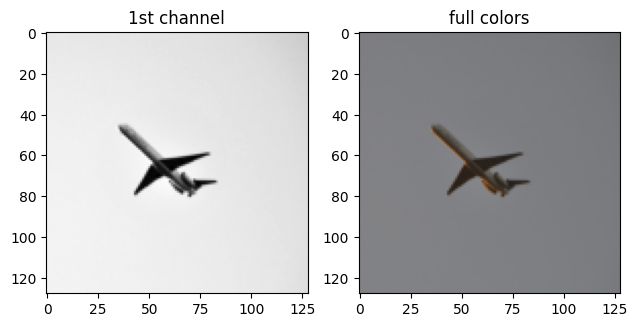

In [5]:
def tensorToImg(tensor:torch.Tensor):
	if len(tensor.shape) == 4:
		tensor = tensor.squeeze(0)
	return tensor.moveaxis(0,2).detach().cpu().numpy()


img1, img2 = test_dataset[0]
print(f"Images shapes :{img1.shape} (input)")

fig = plt.figure()
ax1, ax2 = fig.subplots(1, 2)

ax1.imshow(tensorToImg(img1), cmap="grey")
ax1.set_title("1st channel")


print(f"Images shapes :{img2.shape} (target)")

# ax2.imshow(color.lab2rgb(tensorToImg(img2)))
ax2.imshow(color.lab2rgb(tensorToImg(UnNormalize(img2))))
ax2.set_title("full colors")
plt.tight_layout()

In [6]:
from tqdm import tqdm

# Training loop
def train_loop(dataloader, model, loss_fn, optimizer, verbose = True):
	size = len(dataloader.dataset)
	model = model.to(device)
	model.train()
	train_loss = 0

	for (X, y) in (tqdm(dataloader, desc="train") if verbose else dataloader):
		# Compute prediction and loss
		X = X.to(device)
		y = y.to(device)
		pred = model(X)
		loss = loss_fn(pred, y)

		# Backpropagation
		optimizer.zero_grad()
		loss.backward()
		optimizer.step()

		train_loss += loss.item()

	return train_loss / size

# Test loop
def test_loop(dataloader, model, loss_fn, verbose = True):
	size = len(dataloader.dataset)
	model = model.to(device)
	model.eval()
	test_loss = 0

	with torch.no_grad():
		for (X, y) in (tqdm(dataloader, desc="test") if verbose else dataloader):
			X = X.to(device)
			y = y.to(device)
			pred = model(X)
			test_loss += loss_fn(pred, y).item()
	return test_loss / size

In [7]:
def select_n_random(data, n=3):
    perm = torch.randperm(len(data))
    listData = [data[perm[i]] for i in range(n)]
    return listData

def plot_images_colorization(model, data):
    model.eval()
    
    fig = plt.figure()
    axes = fig.subplots(len(data), 3)
    for i, (ax1, ax2, ax3) in enumerate(axes):
        img1, img2 = data[i]
        img1 = img1.unsqueeze(0).to(device)
        with torch.no_grad():
            out = model(img1)
        img1 = img1[0][0].unsqueeze(0)
        img1 = img1.cpu()
        ax1.imshow(tensorToImg(img1), cmap="grey")
        # ax2.imshow(color.lab2rgb(tensorToImg(out)))
        ax2.imshow(color.lab2rgb(tensorToImg(UnNormalize(out))))
        # ax3.imshow(color.lab2rgb(tensorToImg(img2)))
        ax3.imshow(color.lab2rgb(tensorToImg(UnNormalize(img2))))
        ax1.axis("off")
        ax2.axis("off")
        ax3.axis("off")
    return fig

# Overfit

In [12]:
from src.Models import NetworkColor

# Define the model
model = NetworkColor()

# Define the loss function
criterion = nn.L1Loss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [13]:
# Dataloaders
overfit_dataset = [train_dataset[i] for i in range(10)]
train_loader = dataloader.DataLoader(overfit_dataset, shuffle=True, batch_size=1)

Done!


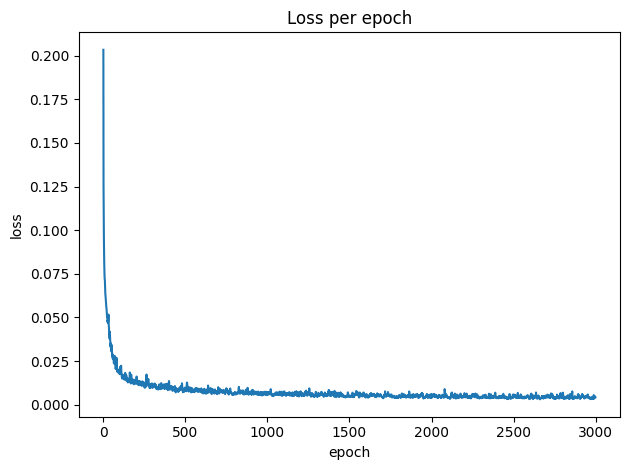

In [14]:
# Set the number of epochs
num_epochs = 3000

tot_loss = []
for t in range(num_epochs):
    tot_loss.append(train_loop(train_loader, model, criterion, optimizer, verbose=False))
        
print("Done!")

plt.plot(tot_loss)
plt.title("Loss per epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.tight_layout()

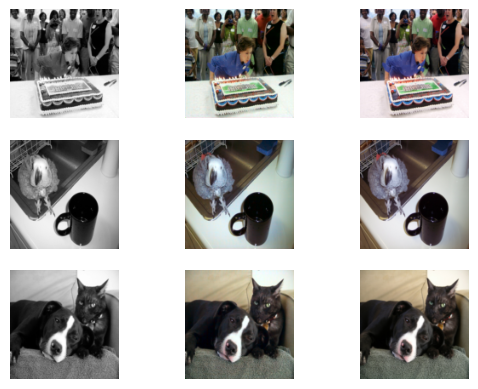

In [ ]:
data = select_n_random(overfit_dataset, n=3)

fig = plot_images_colorization(model, data)

# Train

In [10]:
from src.Models import NetworkColor

# Define the model
model = NetworkColor()

# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Dataloaders
train_loader = dataloader.DataLoader(train_dataset, shuffle=True, batch_size=256)
test_loader = dataloader.DataLoader(test_dataset, shuffle=False, batch_size=256)

In [12]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

# Set the number of epochs
num_epochs = 20

for t in range(num_epochs):
    print(f"Epoch {t+1} -------------------------------")
    train_loss = train_loop(train_loader, model, criterion, optimizer, verbose=True)
    test_loss = test_loop(test_loader, model, criterion, verbose=False)

    # write loss to tensorboard 
    writer.add_scalar("Loss/train", train_loss, t)
    writer.add_scalar("Loss/test", test_loss, t)

    # write images to tensorboard
    data = select_n_random(train_dataset, n=4)
    writer.add_figure('grey/colorized/real',
                        plot_images_colorization(model,data),
                        global_step=t+1)
    writer.flush()
        

print("Done!")
writer.close()

Epoch 1 -------------------------------


train: 100%|██████████| 159/159 [29:15<00:00, 11.04s/it]
/tmp/ipykernel_19177/1881612909.py:20: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 1 negative Z values that have been clipped to zero
  ax2.imshow(color.lab2rgb(tensorToImg(UnNormalize(out))))


Epoch 2 -------------------------------


train: 100%|██████████| 159/159 [28:15<00:00, 10.66s/it]


Epoch 3 -------------------------------


train: 100%|██████████| 159/159 [28:09<00:00, 10.63s/it]


Epoch 4 -------------------------------


train: 100%|██████████| 159/159 [28:15<00:00, 10.66s/it]


Epoch 5 -------------------------------


train: 100%|██████████| 159/159 [28:06<00:00, 10.61s/it]
/tmp/ipykernel_19177/1881612909.py:20: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 9 negative Z values that have been clipped to zero
  ax2.imshow(color.lab2rgb(tensorToImg(UnNormalize(out))))


Epoch 6 -------------------------------


train: 100%|██████████| 159/159 [28:13<00:00, 10.65s/it]


Epoch 7 -------------------------------


train: 100%|██████████| 159/159 [28:11<00:00, 10.64s/it]


Epoch 8 -------------------------------


train: 100%|██████████| 159/159 [28:10<00:00, 10.63s/it]


Epoch 9 -------------------------------


train: 100%|██████████| 159/159 [28:14<00:00, 10.66s/it]


Epoch 10 -------------------------------


train: 100%|██████████| 159/159 [28:03<00:00, 10.59s/it]


Epoch 11 -------------------------------


train: 100%|██████████| 159/159 [28:01<00:00, 10.57s/it]


Epoch 12 -------------------------------


train: 100%|██████████| 159/159 [28:05<00:00, 10.60s/it]


Epoch 13 -------------------------------


train: 100%|██████████| 159/159 [28:12<00:00, 10.65s/it]


Epoch 14 -------------------------------


train: 100%|██████████| 159/159 [28:08<00:00, 10.62s/it]


Epoch 15 -------------------------------


train: 100%|██████████| 159/159 [27:58<00:00, 10.56s/it]


Epoch 16 -------------------------------


train: 100%|██████████| 159/159 [27:49<00:00, 10.50s/it]


Epoch 17 -------------------------------


train: 100%|██████████| 159/159 [28:01<00:00, 10.58s/it]


Epoch 18 -------------------------------


train: 100%|██████████| 159/159 [27:57<00:00, 10.55s/it]


Epoch 19 -------------------------------


train: 100%|██████████| 159/159 [27:59<00:00, 10.56s/it]


Epoch 20 -------------------------------


train: 100%|██████████| 159/159 [27:49<00:00, 10.50s/it]


Done!


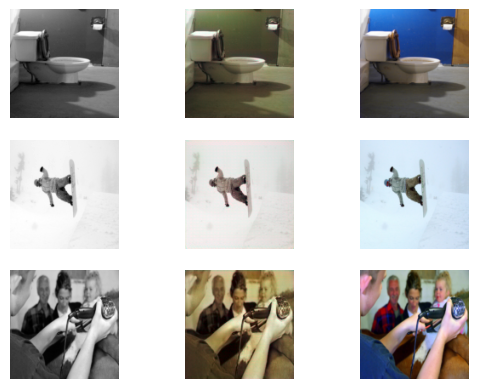

In [43]:
data = select_n_random(train_dataset, n=3)

fig = plot_images_colorization(model, data)

In [ ]:
from src.Models import save_model

save = True

if save:
    save_model(model)